A calculator for determining the orifice geometry for a LOX centered Pintle design. 

Currently a work in progress.


# Pinte V3 Calculator: current

Calculator for use with Pintle V3 CAD design. 

This calculator uses the following inputs:

Mass flow rates: kg/s
Fluid type: water, IPA, LOX

Pintle and Annulus geometry, use imperial units and standard drill sizes, code will convert to metric


**Things to add**
- Will need to add a drawing which shows which dimensions relate to which geometry for the design

- Add TMR


**Added**
- Blockage factor
- turbulence intensity
- turbulence length scale
- Exit weber numbers



In [1]:
#Pintle V3 calculator

import math
from mpmath import *
import numpy as np
from matplotlib import pyplot as plt


# Desired flow parameters

of_ratio = 0.4082 / 0.562

pintle_mdot = 0.4082    # kg/s  , desired Pintle mass flow rate (0.4082 design)
annulus_mdot = pintle_mdot / of_ratio   # kg/s  , desired Annulus mass flow rate (0.5262 design)

# Fluid properties

fluid_pintle  = 'water'
fluid_annulus = 'water'

if fluid_pintle == 'water':
    pintle_rho             = 999.7     # kg/m^3
    pintle_dynvisc         = 0.001307  # N*s/m^2
    pintle_surface_tension = 0.0720    # N/m

elif fluid_pintle == 'LOX':
    pintle_rho             = 1141      # kg/m^3
    pintle_dynvisc         = 0.0001971 # N*s/m^2
    pintle_surface_tension = 0.01135   # N/m

if fluid_annulus == 'water':
    annulus_rho            = 999.7     # kg/m^3
    annulus_dynvisc        = 0.001307  # N*s/m^2
    annulus_surface_tension= 0.0720    # N/m 

elif fluid_annulus == 'IPA':
    annulus_rho       = 877.8         # kg/m^3  
    annulus_dynvisc   = 0.002         # N*s/m^2
    annulus_surface_tension= 0.0720*0.3 + 0.0209*0.7    # N/m 70% IPA estimate
    

# V_3.0 geometry

def inch_to_meters(inch):
    meter = inch / 39.36996
    return(meter)

pintle_entrance_dia   = inch_to_meters(0.44)     # 0.44 
pintle_inner_dia      = inch_to_meters(0.221)    # 0.221
pintle_exit_dia       = inch_to_meters(0.04)   # 0.0595   
pintle_outer_dia      = inch_to_meters(0.421)    # 0.421
pintle_number_outlets = 12

annulus_entrance_dia  = inch_to_meters(0.25)     # 0.25 
annulus_chamber_dia   = inch_to_meters(0.865)    # 0.865
annulus_channel_depth = inch_to_meters(0.21)     # 0.21
annulus_channel_width = inch_to_meters(0.25)     # 0.25
annulus_outer_dia     = inch_to_meters(0.48)   #0.4844
annulus_hydrolic_dia  = annulus_outer_dia - pintle_outer_dia
annular_gap           = (annulus_outer_dia - pintle_outer_dia) / 2


    
# Area calculations

pintle_entrance_area  = math.pi*(pintle_entrance_dia/2)**2          # m^2 , flow area 1
pintle_inner_area     = math.pi*(pintle_inner_dia/2)**2             # m^2 , flow area 2
pintle_exit_area      = pintle_number_outlets * math.pi*(pintle_exit_dia/2)**2         # m^2 , flow area 3, 12 small diameter holes

annulus_entrance_area = (math.pi*(annulus_entrance_dia/2)**2)*3     # m^2 , flow area 1
annulus_manifold_area = (annulus_channel_depth * annulus_channel_width)* 6  # m^2 , flow area 2
annulus_channel_area  = (annulus_channel_depth * annulus_channel_width)* 3  # m^2 , flow area 3
annulus_chamber_area  = math.pi*(annulus_chamber_dia/2)**2          # m^2 , flow area 4
annulus_inner_area    = math.pi*(pintle_outer_dia/2)**2                    # m^2 
annulus_outer_area    = math.pi*(annulus_outer_dia/2)**2            # m^2 
annulus_exit_area     = annulus_outer_area - annulus_inner_area     # m^2 , flow area 5


# velocity calculations

pintle_entrance_velocity  = pintle_mdot / (pintle_rho * pintle_entrance_area)  
pintle_inner_velocity     = pintle_mdot / (pintle_rho * pintle_inner_area)  
pintle_exit_velocity      = pintle_mdot / (pintle_rho * pintle_exit_area) 


annulus_entrance_velocity = annulus_mdot / (annulus_rho * annulus_entrance_area) 
annulus_manifold_velocity = annulus_mdot / (annulus_rho * annulus_manifold_area)
annulus_channel_velocity  = annulus_mdot / (annulus_rho * annulus_channel_area)
annulus_chamber_velocity  = annulus_mdot / (annulus_rho * annulus_chamber_area)  
annulus_exit_velocity     = annulus_mdot / (annulus_rho * annulus_exit_area) 

# Entrance Dynamic Pressure

pintle_dynamic_pressure_in = (pintle_rho*pintle_entrance_velocity**2/2)* 0.1450377/1000
annulus_dynamic_pressure_in = (annulus_rho*annulus_entrance_velocity**2/2)* 0.1450377/1000

# Reynolds numbers

pintle_re_1 = (pintle_rho*pintle_entrance_velocity*pintle_entrance_dia)/pintle_dynvisc 
pintle_re_2 = (pintle_rho*pintle_inner_velocity*pintle_inner_dia)/pintle_dynvisc 
pintle_re_3 = (pintle_rho*pintle_exit_velocity*pintle_exit_dia)/pintle_dynvisc 

annulus_re_1 = (annulus_rho*annulus_entrance_velocity*annulus_entrance_dia)/annulus_dynvisc 
annulus_re_3 = (annulus_rho*annulus_channel_velocity*
                ((4*annulus_channel_area)/(2*annulus_channel_depth+2*annulus_channel_width))
               )/annulus_dynvisc 
annulus_re_4 = (annulus_rho*annulus_chamber_velocity*annulus_chamber_dia)/annulus_dynvisc 
annulus_re_5 = (annulus_rho*annulus_exit_velocity*annulus_hydrolic_dia)/annulus_dynvisc 

# Loss coefficents; taken from Fluids textbook

pintle_k_1 = 0.07   # loss coefficient for first entrance region (from Munson)
pintle_k_2 = 2      # inner region for transition between centeral flow path and radial holes (guess based on Munson)
pintle_k_3 = 1      # Exit region to atmosphere (from Munson)


annulus_k_1 = 0.07         # Transition from entrance to manifold  (2.25 guess based on Munson)
annulus_k_2 = 4      # Transition between manifold and 3 inner channels (2.8 guess based on Munson)
annulus_k_3 = 1.2    # Transition from channels into annular chamber (from Munson)
                         #(1-annulus_channel_area/annulus_chamber_area)**2
annulus_k_4 = 2         # Transition from upper fuel chamber diameter to annular gap (0.07 from Munson)
annulus_k_5 = 1.75        # exit region to atmosphere (1 from Munson)


# calculated head losses in kPa

pintle_hL_1 = (pintle_k_1*0.5*pintle_rho*pintle_entrance_velocity**2)/1000 
pintle_hL_2 = (pintle_k_2*0.5*pintle_rho*pintle_inner_velocity**2)/1000 
pintle_hL_3 = (pintle_k_3*0.5*pintle_rho*pintle_exit_velocity**2)/1000 
pintle_hl_tot = pintle_hL_1 + pintle_hL_2+pintle_hL_3

annulus_hL_1 = (annulus_k_1*0.5*annulus_rho*annulus_entrance_velocity**2)/1000 
annulus_hL_2 = (annulus_k_2*0.5*annulus_rho*annulus_manifold_velocity**2)/1000
annulus_hL_3 = (annulus_k_3*0.5*annulus_rho*annulus_channel_velocity**2)/1000
annulus_hL_4 = (annulus_k_4*0.5*annulus_rho*annulus_chamber_velocity**2)/1000 
annulus_hL_5 = (annulus_k_5*0.5*annulus_rho*annulus_exit_velocity**2)/1000  
annulus_hl_tot = annulus_hL_1 + annulus_hL_2 + annulus_hL_3 + annulus_hL_4 + annulus_hL_5

#convert to psi from kPa for head loss

pintle_hL_1_psi = pintle_hL_1 * 0.1450377    
pintle_hL_2_psi = pintle_hL_2 * 0.1450377    
pintle_hL_3_psi = pintle_hL_3 * 0.1450377    
pintle_hL_total_psi = (pintle_hL_1_psi+pintle_hL_2_psi+pintle_hL_3_psi)  

annulus_hL_1_psi = annulus_hL_1 * 0.1450377  
annulus_hL_2_psi = annulus_hL_2 * 0.1450377    
annulus_hL_3_psi = annulus_hL_3 * 0.1450377    
annulus_hL_4_psi = annulus_hL_4 * 0.1450377
annulus_hL_5_psi = annulus_hL_5 * 0.1450377
annulus_hL_total_psi = (annulus_hL_1_psi+annulus_hL_2_psi+annulus_hL_3_psi+
                        annulus_hL_4_psi+annulus_hL_5_psi)  


# calculate overal loss coefficient
pintle_K_L = (2*pintle_hl_tot*1000)/(pintle_rho*pintle_exit_velocity**2)
pintle_K_L_alt = pintle_mdot/(pintle_exit_area*math.sqrt(2*pintle_rho*pintle_hl_tot*1000))
annulus_K_L = (2*annulus_hl_tot*1000)/(annulus_rho*annulus_exit_velocity**2)

print(pintle_K_L_alt)

# calulcate Velocity scale
pintle_velocity_scale = pintle_entrance_velocity * 0.1
annulus_velocity_scale = annulus_entrance_velocity * 0.1

# calculate Turbulence intensity

pintle_turbulence_intensity = math.sqrt((3*pintle_velocity_scale**2)/(2*pintle_entrance_velocity**2))
annulus_turbulence_intensity = math.sqrt((3*annulus_velocity_scale**2)/(2*annulus_entrance_velocity**2))


# calculate Turbulence length scale

pintle_turbulence_length = 0.38 * pintle_entrance_dia * 1000 
annulus_turbulence_length = 0.38 * annulus_entrance_dia * 1000

# calculate exit weber numbers

pintle_exit_weber = (pintle_rho*pintle_exit_velocity**2*pintle_exit_dia)/(pintle_surface_tension)
annulus_exit_weber = (annulus_rho*annulus_exit_velocity**2*annular_gap)/(annulus_surface_tension)

# blockage factor

pintle_blockage_factor = (pintle_number_outlets*pintle_exit_dia) / (math.pi*pintle_outer_dia)

# Momentum Ratio

pintle_force = pintle_rho * pintle_exit_velocity**2 * math.pi*(pintle_exit_dia/2)**2
annulus_force = annulus_rho * annulus_exit_velocity**2 * annular_gap * pintle_exit_dia


pintle_force2 = pintle_rho * pintle_exit_velocity**2 * math.pi*(pintle_exit_dia/2)**2*12
annulus_force2 = annulus_rho * annulus_exit_velocity**2 * annulus_exit_area


momentum_ratio = annulus_force / pintle_force
momentum_ratio2 = annulus_force2 / pintle_force2



print("Pintle V3: Calculated flow values\n")
print('Pintle calculations if using %s\n' %fluid_pintle)

print('Pintle entrance velocity        = %8.3f m/s' % pintle_entrance_velocity)
#print('Pintle inner velocity       = %8.3f m/s' % pintle_inner_velocity)
print('Pintle exit velocity            = %8.3f m/s \n' % pintle_exit_velocity)

print('Pintle entrance Reynolds #  = %8.0f' % pintle_re_1)
#print('Pintle Reynolds # 2         = %10.0f' % pintle_re_2)
print('Pintle exit Reynolds #      = %8.0f \n' % pintle_re_3)
print('Pintle headloss 1           = %8.3f psi' % pintle_hL_1_psi)
print('Pintle headloss 2           = %8.3f psi' % pintle_hL_2_psi)
print('Pintle headloss 3           = %8.3f psi\n' % pintle_hL_3_psi)


print('Pintle Total head loss           = %8.2f psi' % pintle_hL_total_psi)
print('Pintle  Total head loss          = %8.3f kPa' % pintle_hl_tot)
print('Pintle  KL total                 = %8.3f \n ' % pintle_K_L)
print('Pintle turbulence intensity      = %8.4f ' % pintle_turbulence_intensity)
print('Pintle turbulence length scale   = %8.3f mm ' % pintle_turbulence_length)
print('Pintle exit weber number         = %8.3f \n' % pintle_exit_weber)

print('Pintle exit diameter             = %8.7f \n' % pintle_exit_dia)

print('Pintle Entrance Dynamic Pressure = %8.3f psi \n' % pintle_dynamic_pressure_in)
print('Pintle blockage factor           = %8.3f \n' % pintle_blockage_factor)
print('Momentum Ratio (Ff/Fo)           = %8.3f \n' % momentum_ratio)
print('Total Momentum Ratio (Ff/Fo)     = %8.3f \n' % momentum_ratio2)


print('Annulus calculations if using %s\n' %fluid_annulus)

print('annulus entrance velocity        = %8.3f m/s' % annulus_entrance_velocity)
#print('annulus inner velocity      = %8.3f m/s' % annulus_chamber_velocity)
print('annulus exit velocity            = %8.3f m/s \n' % annulus_exit_velocity)

print('annulus entrance Reynolds # = %8.0f' % annulus_re_1)
#print('annulus Reynolds # 2        = %10.3f' % annulus_re_2)
print('annulus exit Reynolds #     = %8.0f \n' % annulus_re_5)

print('annulus headloss 1          = %8.3f psi' % annulus_hL_1_psi)
print('annulus headloss 2          = %8.3f psi' % annulus_hL_2_psi)
print('annulus headloss 3          = %8.3f psi' % annulus_hL_3_psi)
print('annulus headloss 4          = %8.3f psi' % annulus_hL_4_psi)
print('annulus headloss 5          = %8.3f psi\n' % annulus_hL_5_psi)

print('annulus Total head loss           = %8.2f psi' % annulus_hL_total_psi)
print('annulus Total head loss           = %8.3f kPa' % annulus_hl_tot)
print('annulus KL total                  = %8.3f \n ' % annulus_K_L)
print('annulus turbulence intensity      = %8.4f ' % annulus_turbulence_intensity)
print('annulus turbulence length scale   = %8.3f mm' % annulus_turbulence_length)
print('annulus exit weber number         = %8.3f \n' % annulus_exit_weber)

print('annular gap                       = %8.7f m \n' % annular_gap)
print('annulus Entrance Dynamic Pressure = %8.3f \n' % annulus_dynamic_pressure_in)



0.8737830649667246
Pintle V3: Calculated flow values

Pintle calculations if using water

Pintle entrance velocity        =    4.162 m/s
Pintle exit velocity            =   41.970 m/s 

Pintle entrance Reynolds #  =    35581
Pintle exit Reynolds #      =    32616 

Pintle headloss 1           =    0.088 psi
Pintle headloss 2           =   39.470 psi
Pintle headloss 3           =  127.704 psi

Pintle Total head loss           =   167.26 psi
Pintle  Total head loss          = 1153.232 kPa
Pintle  KL total                 =    1.310 
 
Pintle turbulence intensity      =   0.1225 
Pintle turbulence length scale   =    4.247 mm 
Pintle exit weber number         = 24849.434 

Pintle exit diameter             = 0.0010160 

Pintle Entrance Dynamic Pressure =    1.256 psi 

Pintle blockage factor           =    0.363 

Momentum Ratio (Ff/Fo)           =    0.232 

Total Momentum Ratio (Ff/Fo)     =    0.685 

Annulus calculations if using water

annulus entrance velocity        =    5.917 m/s
a

## Pintle V3 Design Tool Spreadsheet generator for CFD

The code below will create a spreadsheet of values for a specific V3 geometry over a range of mass flow rate inputs. The output of this file is useful for obtaining reasonable initial conditions for CFD modeling. The data can also be graphed to obtain a theoretical mass flow rate vs pressure curve for the design.

In [2]:
import math
import csv


pintle_mdot =  [.16, .19, .22, .25, .28, .31, .33, .36, .39, .42, .45, .48]    
              # kg/s  , desired Pintle mass flow rate (0.4082 design)
annulus_mdot = [.19, .25, .28, .31, .33, .36, .39, .42, .45, .48, .51, 0.54]   
               # kg/s  , desired Annulus mass flow rate (0.5262 design)

#pintle_mdot =  [.06, .08, .1, .12, .14, .16, .18, .20, .22, .23, .24, .45]

#annulus_mdot = [.04, .05, .06, .07, .08, .09, .1, .11, .12, .13, .14, .15]

# Desired flow parameters, enter the range of outputs desired
#pintle_mdot =  [.1, .2, .3, .4, .5, .4082, .6, .7, .8, .9, 1, 1.5]    
              # kg/s  , desired Pintle mass flow rate (0.4082 design)
#annulus_mdot = [.1, .2, .3, .4, .5, .5262, .6, .7, .8, .9, 1, 1.5]   
               # kg/s  , desired Annulus mass flow rate (0.5262 design)

def inch_to_meters(inch):
    meter = inch / 39.36996
    return(meter)

def meters_to_inch(meter):
    inch = meter * 39.36996
    return(inch)

pintle_entrance_dia   = inch_to_meters(0.44)   
pintle_inner_dia      = inch_to_meters(0.221)      
pintle_exit_dia       = inch_to_meters(0.0595)      
pintle_outer_dia      = inch_to_meters(0.421)
pintle_number_outlets = 12


annulus_entrance_dia  = inch_to_meters(0.25)      
annulus_chamber_dia   = inch_to_meters(0.865)    
annulus_channel_depth = inch_to_meters(0.21)   
annulus_channel_width = inch_to_meters(0.25)     
annulus_outer_dia     = inch_to_meters(0.46875)
annulus_hydrolic_dia  = annulus_outer_dia - pintle_outer_dia
annular_gap           = (annulus_outer_dia - pintle_outer_dia) / 2


# Fluid properties

fluid_pintle  = 'water'
fluid_annulus = 'water'

if fluid_pintle == 'water':
    pintle_rho             = 999.7     # kg/m^3
    pintle_dynvisc         = 0.001307  # N*s/m^2
    pintle_surface_tension = 0.0720    # N/m

elif fluid_pintle == 'LOX':
    pintle_rho             = 1141      # kg/m^3
    pintle_dynvisc         = 0.0001971 # N*s/m^2
    pintle_surface_tension = 0.01135   # N/m

if fluid_annulus == 'water':
    annulus_rho            = 999.7     # kg/m^3
    annulus_dynvisc        = 0.001307  # N*s/m^2
    annulus_surface_tension= 0.0720    # N/m 

elif fluid_annulus == 'IPA':
    annulus_rho       = 877.8         # kg/m^3  
    annulus_dynvisc   = 0.002         # N*s/m^2
    annulus_surface_tension= 0.0720*0.3 + 0.0209*0.7    # N/m 70% IPA estimate

# Loss coefficents; taken from Fluids textbook


pintle_k_1 = 0.07   # loss coefficient for first entrance region (from Munson)
pintle_k_2 = 2      # inner region for transition between centeral flow path and radial holes (guess based on Munson)
pintle_k_3 = 1      # Exit region to atmosphere (from Munson)


annulus_k_1 = 0.07         # Transition from entrance to manifold  (2.25 guess based on Munson)
annulus_k_2 = 4      # Transition between manifold and 3 inner channels (2.8 guess based on Munson)
annulus_k_3 = 1.2    # Transition from channels into annular chamber (from Munson)
                         #(1-annulus_channel_area/annulus_chamber_area)**2
annulus_k_4 = 2         # Transition from upper fuel chamber diameter to annular gap (0.07 from Munson)
annulus_k_5 = 1.75        # exit region to atmosphere (1 from Munson)




    
# Area calculations

pintle_entrance_area  = math.pi*(pintle_entrance_dia/2)**2          # m^2 , flow area 1
pintle_inner_area     = math.pi*(pintle_inner_dia/2)**2             # m^2 , flow area 2


pintle_exit_area    = pintle_number_outlets * math.pi*(pintle_exit_dia/2)**2         # m^2 , flow area 3, 12 small diameter holes


annulus_entrance_area = (math.pi*(annulus_entrance_dia/2)**2)*3     # m^2 , flow area 1
annulus_manifold_area = (annulus_channel_depth * annulus_channel_width)* 6  # m^2 , flow area 2
annulus_channel_area  = (annulus_channel_depth * annulus_channel_width)* 3  # m^2 , flow area 3
annulus_chamber_area  = math.pi*(annulus_chamber_dia/2)**2          # m^2 , flow area 4
annulus_inner_area    = math.pi*(pintle_outer_dia/2)**2                    # m^2 
annulus_outer_area    = math.pi*(annulus_outer_dia/2)**2            # m^2 
annulus_exit_area     = annulus_outer_area - annulus_inner_area     # m^2 , flow area 5


pintle_entrance_velocity = []; pintle_inner_velocity = []; pintle_exit_velocity = []
annulus_entrance_velocity = []; annulus_manifold_velocity = []; annulus_channel_velocity = []
annulus_chamber_velocity = []; annulus_exit_velocity = []

pintle_dynamic_pressure_in = []; annulus_dynamic_pressure_in = []
pintle_entrance_re = []; pintle_exit_re = []
annulus_entrance_re = []; annulus_exit_re = []

pintle_hl_tot = []; pintle_hL_total_psi = []
annulus_hl_tot = []; annulus_hL_total_psi = []
pintle_K_L = []; annulus_K_L = []
pintle_velocity_scale = [] ; annulus_velocity_scale = []
pintle_turbulence_intensity = [] ; annulus_turbulence_intensity = []
pintle_exit_weber = [] ; annulus_exit_weber = []

pintle_force = [] ; annulus_force = [] ; pintle_force_tot = [] ; annulus_force_tot = []
momentum_ratio = [] ; momentum_ratio_tot = []


# Pintle calculations

for i,value in enumerate(pintle_mdot):

# Velocity calculations 
    pintle_entrance_velocity.append(pintle_mdot[i] / (pintle_rho * pintle_entrance_area))  
    pintle_inner_velocity.append(pintle_mdot[i] / (pintle_rho * pintle_inner_area))  
    pintle_exit_velocity.append(pintle_mdot[i] / (pintle_rho * pintle_exit_area)) 

# Entrance Dynamic Pressure
    pintle_dynamic_pressure_in.append((pintle_rho*pintle_entrance_velocity[i]**2/2)* 0.1450377/1000)
    
# Reynolds numbers
    pintle_entrance_re.append((pintle_rho*pintle_entrance_velocity[i]*pintle_entrance_dia)/pintle_dynvisc )
    pintle_exit_re.append((pintle_rho*pintle_exit_velocity[i]*pintle_exit_dia)/pintle_dynvisc )

# calculated head losses in kPa
    pintle_hL_1 = (pintle_k_1*0.5*pintle_rho*pintle_entrance_velocity[i]**2)/1000 
    pintle_hL_2 = (pintle_k_2*0.5*pintle_rho*pintle_inner_velocity[i]**2)/1000 
    pintle_hL_3 = (pintle_k_3*0.5*pintle_rho*pintle_exit_velocity[i]**2)/1000 
    pintle_hl_tot.append(pintle_hL_1 + pintle_hL_2+pintle_hL_3)

#convert to psi from kPa for head loss
    pintle_hL_1_psi = pintle_hL_1 * 0.1450377    
    pintle_hL_2_psi = pintle_hL_2 * 0.1450377    
    pintle_hL_3_psi = pintle_hL_3 * 0.1450377    
    pintle_hL_total_psi.append((pintle_hL_1_psi+pintle_hL_2_psi+pintle_hL_3_psi))  

# calculate overal loss coefficient
    pintle_K_L.append((2*pintle_hl_tot[i]*1000)/(pintle_rho*pintle_exit_velocity[i]**2))

# calulcate Velocity scale
    pintle_velocity_scale.append(pintle_entrance_velocity[i] * 0.1)

# calculate Turbulence intensity
    pintle_turbulence_intensity.append(math.sqrt((3*pintle_velocity_scale[i]**2)
                                                 /(2*pintle_entrance_velocity[i]**2)))

# calculate exit weber numbers
    pintle_exit_weber.append((pintle_rho*pintle_exit_velocity[i]**2*pintle_exit_dia)
                             /(pintle_surface_tension))
    
# Annulus calculations

for i,value in enumerate(annulus_mdot):

# Velocity calculations
    annulus_entrance_velocity.append(annulus_mdot[i] / (annulus_rho * annulus_entrance_area)) 
    annulus_manifold_velocity.append(annulus_mdot[i] / (annulus_rho * annulus_manifold_area))
    annulus_channel_velocity.append(annulus_mdot[i] / (annulus_rho * annulus_channel_area))
    annulus_chamber_velocity.append(annulus_mdot[i] / (annulus_rho * annulus_chamber_area))  
    annulus_exit_velocity.append(annulus_mdot[i] / (annulus_rho * annulus_exit_area)) 

# Entrance Dynamic Pressure
    annulus_dynamic_pressure_in.append((annulus_rho*annulus_entrance_velocity[i]**2/2)* 0.1450377/1000)

# Reynolds numbers
    annulus_entrance_re.append((annulus_rho*annulus_entrance_velocity[i]*annulus_entrance_dia)/annulus_dynvisc) 
    annulus_exit_re.append((annulus_rho*annulus_exit_velocity[i]*annulus_hydrolic_dia)/annulus_dynvisc) 

# calculated head losses in kPa
    annulus_hL_1 = (annulus_k_1*0.5*annulus_rho*annulus_entrance_velocity[i]**2)/1000 
    annulus_hL_2 = (annulus_k_2*0.5*annulus_rho*annulus_manifold_velocity[i]**2)/1000
    annulus_hL_3 = (annulus_k_3*0.5*annulus_rho*annulus_channel_velocity[i]**2)/1000
    annulus_hL_4 = (annulus_k_4*0.5*annulus_rho*annulus_chamber_velocity[i]**2)/1000 
    annulus_hL_5 = (annulus_k_5*0.5*annulus_rho*annulus_exit_velocity[i]**2)/1000  
    annulus_hl_tot.append(annulus_hL_1 + annulus_hL_2 + annulus_hL_3 + annulus_hL_4 + annulus_hL_5)

#convert to psi from kPa for head loss
    annulus_hL_1_psi = annulus_hL_1 * 0.1450377  
    annulus_hL_2_psi = annulus_hL_2 * 0.1450377    
    annulus_hL_3_psi = annulus_hL_3 * 0.1450377    
    annulus_hL_4_psi = annulus_hL_4 * 0.1450377
    annulus_hL_5_psi = annulus_hL_5 * 0.1450377
    annulus_hL_total_psi.append((annulus_hL_1_psi+annulus_hL_2_psi+annulus_hL_3_psi+
                            annulus_hL_4_psi+annulus_hL_5_psi))  

# calculate overal loss coefficient
    annulus_K_L.append((2*annulus_hl_tot[i]*1000)/(annulus_rho*annulus_exit_velocity[i]**2))

# calulcate Velocity scale
    annulus_velocity_scale.append(annulus_entrance_velocity[i] * 0.1)

# calculate Turbulence intensity
    annulus_turbulence_intensity.append(math.sqrt((3*annulus_velocity_scale[i]**2)
                                                  /(2*annulus_entrance_velocity[i]**2)))
# calculate exit weber numbers
    annulus_exit_weber.append((annulus_rho*annulus_exit_velocity[i]**2*annular_gap)
                              /(annulus_surface_tension))

# Momentum ratios
    pintle_force.append(pintle_rho * pintle_exit_velocity[i]**2 * math.pi*(pintle_exit_dia/2)**2)
    annulus_force.append(annulus_rho * annulus_exit_velocity[i]**2 * annular_gap * pintle_exit_dia)

    pintle_force_tot.append(pintle_rho * pintle_exit_velocity[i]**2 * math.pi*(pintle_exit_dia/2)**2*12)
    annulus_force_tot.append(annulus_rho * annulus_exit_velocity[i]**2 * annulus_exit_area)

    momentum_ratio.append(annulus_force[i] / pintle_force[i])
    momentum_ratio_tot.append(annulus_force_tot[i] / pintle_force_tot[i])


    
# calculate Turbulence length scale
pintle_turbulence_length = 0.38 * pintle_entrance_dia * 1000 
annulus_turbulence_length = 0.38 * annulus_entrance_dia * 1000

# blockage factor

pintle_blockage_factor = (pintle_number_outlets*pintle_exit_dia) / (math.pi*pintle_outer_dia)
    
header_1 = ['Pintle', 'values', 'units']

pintle_dimensions = [['Entrance diameter', str(meters_to_inch(pintle_entrance_dia)), 'in'],
               ['Inner Diameter', str(meters_to_inch(pintle_inner_dia)), 'in'],
               ['Outer Diameter', str(meters_to_inch(pintle_outer_dia)), 'in'],
               ['Exit Diameter', str(meters_to_inch(pintle_exit_dia)), 'in'],
               ['Number of Orifices', str(pintle_number_outlets), ' '],
               ['Blockage Factor', str(pintle_blockage_factor), '']]

spacer = [' ', ' ', ' ']
header_2 = ['Annulus', 'values', 'units']

annulus_dimensions = [['Entrance diameter', str(meters_to_inch(annulus_entrance_dia)), 'in'],
               ['Channel Width', str(meters_to_inch(annulus_channel_width)), 'in'],
               ['Channel Depth', str(meters_to_inch(annulus_channel_depth)), 'in'],
               ['Chamber Diameter', str(meters_to_inch(annulus_chamber_dia)), 'in'],
               ['Annulus Outer Diameter', str(meters_to_inch(annulus_outer_dia)), 'in'],
               ['Annular Gap', str(meters_to_inch(annular_gap)), 'in']]

header_3 = ['Pintle Version', 'Estimated Loss coef', 'Working Fluid', 'T intensity', 'T lenght Scale mm']
pintle_data_1 = ['pintle V3', str(sum(pintle_K_L)/len(pintle_K_L)), fluid_pintle, 
                 str(sum(pintle_turbulence_intensity)/len(pintle_turbulence_intensity)), 
                 str(pintle_turbulence_length) ]

header_4 = ['Mass Flowrate kg/s', 'Pressure PSI' , 'Pressure kPa','Dynamic Pressure in psi',
            'Velocity Length Scale m/s','Entrance Velocity m/s','Exit Velocity m/s',
           'Entrance Reynolds', 'Exit Reynolds', 'Exit Weber', 'momentum raio orifice', 
            'momentum raito total']

pintle_flow_data = [pintle_mdot, pintle_hL_total_psi, pintle_hl_tot, pintle_dynamic_pressure_in,
                    pintle_velocity_scale, pintle_entrance_velocity, pintle_exit_velocity,
                    pintle_entrance_re, pintle_exit_re, pintle_exit_weber, momentum_ratio, 
                    momentum_ratio_tot]

pintle_flow_data_t = zip(*pintle_flow_data)

header_5 = ['Annulus Version', 'Estimated Loss coef', 'Working Fluid', 'T intensity', 'T lenght Scale mm']
annulus_data_1 = ['Annulus V3', str(sum(annulus_K_L)/len(annulus_K_L)), fluid_annulus, 
                 str(sum(annulus_turbulence_intensity)/len(annulus_turbulence_intensity)), 
                 str(annulus_turbulence_length) ]

header_6 = ['Mass Flowrate kg/s', 'Pressure PSI' , 'Pressure kPa','Dynamic Pressure in psi',
            'Velocity Length Scale m/s','Entrance Velocity m/s','Exit Velocity m/s',
           'Entrance Reynolds', 'Exit Reynolds', 'Exit Weber', 'momentum raio orifice', 
            'momentum raito total']

annulus_flow_data = [annulus_mdot, annulus_hL_total_psi, annulus_hl_tot, annulus_dynamic_pressure_in,
                    annulus_velocity_scale, annulus_entrance_velocity, annulus_exit_velocity,
                    annulus_entrance_re, annulus_exit_re, annulus_exit_weber, momentum_ratio, 
                    momentum_ratio_tot ]

annulus_flow_data_t = zip(*annulus_flow_data)


with open("pintle_v3_calculator_output.csv", "w", newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(header_1) # write the header
     
    # write the actual content line by line
    for i in pintle_dimensions:
        writer.writerow(i)
        
    writer.writerow(spacer)
    writer.writerow(header_3)
    writer.writerow(pintle_data_1)
    
    writer.writerow(spacer)
    writer.writerow(header_4)

    for i in pintle_flow_data_t:
        writer.writerow(i)

    writer.writerow(spacer)
    writer.writerow(header_2)

    for i in annulus_dimensions:
        writer.writerow(i)
        
    writer.writerow(spacer)
    writer.writerow(header_5)
    writer.writerow(annulus_data_1)
        
    writer.writerow(spacer)
    writer.writerow(header_6)

    for i in annulus_flow_data_t:
        writer.writerow(i)

        
print('done')


done


## Test Calculator for momentum ratio

Test to obtain a list of annular gap distances which correspond to standard drill sizes given mass flow rate information.

In [81]:
import math
import numpy as np
import csv
import matplotlib.pyplot as plt


def inch_to_meters(inch):
    meter = inch / 39.36996
    return(meter)

def meters_to_inch(meter):
    inch = meter * 39.36996
    return(inch)


# mass flow rates

pintle_mdot =  1.5 #kg/s 
annulus_mdot = 1 #kg/s 


# Fluid properties

fluid_pintle  = 'water'   #options are 'water' , 'LOX' , and 'IPA'
fluid_annulus = 'water'

# Geometry to be optimized

# Currently tested for pintle exit dia between 0.04" and 0.15", and pintle ID between 0.2" and 0.3"

pintle_exit_dia       = inch_to_meters(np.arange(0.12, 0.18, 0.005))      
pintle_inner_dia      = inch_to_meters(0.26) 
pintle_number_outlets = 12

# Currently tested for annulus OD between 0.4" and 0.8", Pintle OD between 0.3" and 0.7", 
# and annular gap up to 0.175

pintle_outer_dia      = inch_to_meters(0.65)
annulus_outer_dia     = inch_to_meters(np.arange(0.7, 0.96, 0.005))


# other geometry 

pintle_entrance_dia   = inch_to_meters(0.44)   
     
annulus_entrance_dia  = inch_to_meters(0.25)      
annulus_chamber_dia   = inch_to_meters(0.865)    
annulus_channel_depth = inch_to_meters(0.21)   
annulus_channel_width = inch_to_meters(0.25)     
annulus_hydrolic_dia  = annulus_outer_dia - pintle_outer_dia
annular_gap           = (annulus_outer_dia - pintle_outer_dia) / 2


#fluid property values

if fluid_pintle == 'water':
    pintle_rho             = 999.7     # kg/m^3
    pintle_dynvisc         = 0.001307  # N*s/m^2
    pintle_surface_tension = 0.0720    # N/m

elif fluid_pintle == 'LOX':
    pintle_rho             = 1141      # kg/m^3
    pintle_dynvisc         = 0.0001971 # N*s/m^2
    pintle_surface_tension = 0.01135   # N/m

if fluid_annulus == 'water':
    annulus_rho            = 999.7     # kg/m^3
    annulus_dynvisc        = 0.001307  # N*s/m^2
    annulus_surface_tension= 0.0720    # N/m 

elif fluid_annulus == 'IPA':
    annulus_rho       = 877.8         # kg/m^3  
    annulus_dynvisc   = 0.002         # N*s/m^2
    annulus_surface_tension= 0.0720*0.3 + 0.0209*0.7    # N/m 70% IPA estimate
    
# Area calculations

pintle_entrance_area  = math.pi*(pintle_entrance_dia/2)**2          # m^2 , flow area 1
pintle_inner_area     = math.pi*(pintle_inner_dia/2)**2             # m^2 , flow area 2
pintle_exit_area      = pintle_number_outlets * math.pi*(pintle_exit_dia/2)**2      # m^2 , flow area 3, 12 small diameter holes

annulus_entrance_area = (math.pi*(annulus_entrance_dia/2)**2)*3     # m^2 , flow area 1
annulus_manifold_area = (annulus_channel_depth * annulus_channel_width)* 6  # m^2 , flow area 2
annulus_channel_area  = (annulus_channel_depth * annulus_channel_width)* 3  # m^2 , flow area 3
annulus_chamber_area  = math.pi*(annulus_chamber_dia/2)**2          # m^2 , flow area 4
annulus_inner_area    = math.pi*(pintle_outer_dia/2)**2                    # m^2 
annulus_outer_area    = math.pi*(annulus_outer_dia/2)**2            # m^2 
annulus_exit_area     = annulus_outer_area - annulus_inner_area     # m^2 , flow area 5

# variables which will be used later

pintle_entrance_velocity = []; pintle_inner_velocity = []; pintle_exit_velocity = []
annulus_entrance_velocity = []; annulus_manifold_velocity = []; annulus_channel_velocity = []
annulus_chamber_velocity = []; annulus_exit_velocity = []

pintle_entrance_re = []; pintle_exit_re = []
annulus_entrance_re = []; annulus_exit_re = []

pintle_hl_tot = []; pintle_hl_total_psi = []
annulus_hl_tot = []; annulus_hl_total_psi = []
pintle_K_L = []; annulus_K_L = [];
pintle_exit_weber = [] ; annulus_exit_weber = []

pintle_force = [] ; annulus_force = [] ; pintle_force_tot = [] ; annulus_force_tot = []
momentum_ratio = []



# Pintle calculations

for i,value in enumerate(pintle_exit_area):

    # Velocity calculations 
    pintle_exit_velocity.append(pintle_mdot / (pintle_rho * pintle_exit_area[i])) 

    # The equations below were developed using a series of 2^2 factorial experiments.
    # The two variables used for these experiements were the pintle exit diameter and the
    # pintle inner diameter. The experiments were carried out using Star CCM+ CFD software
    # using the V3 injector geometry. These equations were taken from the curve fit produced 
    # for the data using R studio.  
    
    # pintle_kl_x = [lower size, upper size, intercept, exit_dia^2, ID^2, ID, exit_dia*ID]
    pintle_kl_a = [0.04,0.06,-0.5407,1636.1412,0,25.6635,-662.7707]
    pintle_kl_b = [0.06,0.08,2.7784,921.0253,0,0,-286.2515]
    pintle_kl_c = [0.08,0.1,3.9113,415.704,-58.6768,0,0]
    pintle_kl_d = [0.1,0.12,4.4271,931.1344,0,0,-371.7347]
    pintle_kl_e = [0.12,0.14,9.5055,657.6832,0,0,-403.5642]
    pintle_kl_f = [0.14,0.18,-18.128, 1915.254, 0, 172.497, -1552.240]
    
    if pintle_exit_dia[i] < inch_to_meters(0.06):
        loss_coef = pintle_kl_a
    elif pintle_exit_dia[i] < inch_to_meters(0.08): 
        loss_coef = pintle_kl_b
    elif pintle_exit_dia[i] < inch_to_meters(0.1):
        loss_coef = pintle_kl_c
    elif pintle_exit_dia[i] < inch_to_meters(0.12):
        loss_coef = pintle_kl_d
    elif pintle_exit_dia[i] < inch_to_meters(0.14):
        loss_coef = pintle_kl_e
    else:
        loss_coef = pintle_kl_f
        
    x0 = loss_coef[2]
    x1 = loss_coef[3]*meters_to_inch(pintle_exit_dia[i])**2
    x2 = loss_coef[4]*meters_to_inch(pintle_inner_dia)**2
    x3 = loss_coef[5]*meters_to_inch(pintle_inner_dia)
    x4 = loss_coef[6]*(meters_to_inch(pintle_exit_dia[i])*meters_to_inch(pintle_inner_dia))
          
    pintle_K_L.append(x0+x1+x2+x3+x4)  

    
    
    
    
    # head losses in kPa and coverted to psi
    pintle_hl_tot.append((pintle_K_L[i]*0.5*pintle_rho*pintle_exit_velocity[i]**2)/1000)
    pintle_hl_total_psi.append(pintle_hl_tot[i]* 0.1450377)  


# Annulus calculations

for i,value in enumerate(annulus_exit_area):
    
    # Velocity calculations
    annulus_exit_velocity.append(annulus_mdot / (annulus_rho * annulus_exit_area[i])) 

    # calculate overal loss coefficient
                         
    # The equations below were developed using multiple factorial experiments.
    # The three variables were used for these experiements; Annulus OD, Pintle OD, #mass flow rate. 
    # The mass flow rate was found to have only weak correlations to the resutls.
    # pintle inner diameter. The experiments were carried out using Star CCM+ CFD software
    # using the V3 injector geometry. These equations were taken from the curve fit produced 
    # for the data using R studio.  
    
    x0b = 6.566
    x1b = 63.204*meters_to_inch(annulus_outer_dia[i])**2
    x2b = 56.572*meters_to_inch(pintle_outer_dia)**2
    x3b = -22.268*meters_to_inch(annulus_outer_dia[i])
    x4b = -92.496*meters_to_inch(pintle_outer_dia)*meters_to_inch(annulus_outer_dia[i])
    
    annulus_K_L.append(x0b+x1b+x2b+x3b+x4b)

    # annulus head losses in kPa and psi
    annulus_hl_tot.append((annulus_K_L[i]*0.5*annulus_rho*annulus_exit_velocity[i]**2)/1000)
    annulus_hl_total_psi.append(annulus_hl_tot[i]* 0.1450377)  
    
    
# Momentum ratios
for i,value in enumerate(pintle_exit_area):
    
    pintle_force.append(pintle_rho * pintle_exit_velocity[i]**2 * math.pi*(pintle_exit_dia[i]/2)**2)
    annulus_force.append(annulus_rho * annulus_exit_velocity[i]**2 * annular_gap[i] * pintle_exit_dia[i])

    momentum_ratio.append(annulus_force[i] / pintle_force[i])
    
    #print('%8.3f %8.3f \n' % (pintle_K_L2[i],pintle_K_L3[i]))


# blockage factor

pintle_blockage_factor = (pintle_number_outlets*pintle_exit_dia) / (math.pi*pintle_outer_dia)
    
header_pintle_dims = ['Pintle', 'values', 'units']

pintle_dimensions = [['Entrance diameter', str(meters_to_inch(pintle_entrance_dia)), 'in'],
               ['Inner Diameter', str(meters_to_inch(pintle_inner_dia)), 'in'],
               ['Outer Diameter', str(meters_to_inch(pintle_outer_dia)), 'in'],
               ['Number of Orifices', str(pintle_number_outlets), ' '],
               ]

spacer = [' ', ' ', ' ']
header_annulus_dims = ['Annulus', 'values', 'units']

annulus_dimensions = [['Entrance diameter', str(meters_to_inch(annulus_entrance_dia)), 'in'],
               ['Channel Width', str(meters_to_inch(annulus_channel_width)), 'in'],
               ['Channel Depth', str(meters_to_inch(annulus_channel_depth)), 'in'],
               ['Chamber Diameter', str(meters_to_inch(annulus_chamber_dia)), 'in'],
               ]

header_pintle_data_1 = ['Pintle Version', 'Working Fluid']
pintle_data_1 = ['pintle V3', fluid_pintle]

header_pintle_flow = ['Pintle Loss coeff', 'pintle exit dia (in)', 'pintle exit dia (m)', 'Pressure PSI' ,
            'Pressure kPa','Exit Velocity m/s', 'momentum raio orifice', 'Blockage Factor']

pintle_flow_data = [pintle_K_L, meters_to_inch(pintle_exit_dia), pintle_exit_dia,
                    pintle_hl_total_psi, pintle_hl_tot, pintle_exit_velocity,
                    momentum_ratio, pintle_blockage_factor]

pintle_flow_data_t = zip(*pintle_flow_data)

header_annulus_data_1 = ['Annulus Version', 'Working Fluid']
annulus_data_1 = ['Annulus V3', fluid_annulus]

header_annulus_flow = ['Annulus Loss coeff', 'Annulus OD (in)', 'OD (m)', 'Pressure PSI' , 
                       'Pressure kPa','Exit Velocity m/s','momentum raio orifice'
                      ,'gap (in)', 'gap (m)']

annulus_flow_data = [annulus_K_L, meters_to_inch(annulus_outer_dia), annulus_outer_dia,
                    annulus_hl_total_psi, annulus_hl_tot, annulus_exit_velocity, 
                     momentum_ratio, meters_to_inch(annular_gap), annular_gap]

annulus_flow_data_t = zip(*annulus_flow_data)


with open("pintle_mr_calcs.csv", "w", newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(header_pintle_dims) # write the header
     
    # write the actual content line by line
    for i in pintle_dimensions:
        writer.writerow(i)
        
    writer.writerow(spacer)
    writer.writerow(header_pintle_data_1)
    writer.writerow(pintle_data_1)

    writer.writerow(spacer)
    writer.writerow(header_annulus_dims)
    
    for i in annulus_dimensions:
        writer.writerow(i)

    writer.writerow(spacer)
    writer.writerow(header_annulus_data_1)
    writer.writerow(annulus_data_1)

    writer.writerow(spacer)
    writer.writerow(header_pintle_flow)
    for i in pintle_flow_data_t:
        writer.writerow(i)

        
    writer.writerow(spacer)
    writer.writerow(header_annulus_flow)

    for i in annulus_flow_data_t:
        writer.writerow(i)

        
print('done')


done


## Loss Coefficient Calculator
The code below determines an estimated loss coefficient curve over a range of geometries. Can be used to help determine the optimum injector geometry.

In [90]:
import math
import numpy as np
import csv
import matplotlib.pyplot as plt


def inch_to_meters(inch):
    meter = inch / 39.36996
    return(meter)

def meters_to_inch(meter):
    inch = meter * 39.36996
    return(inch)


# mass flow rates

pintle_mdot =  1.5 #kg/s 
annulus_mdot = 1 #kg/s 


# Fluid properties

fluid_pintle  = 'water'   #options are 'water' , 'LOX' , and 'IPA'
fluid_annulus = 'water'

# Geometry to be optimized

# Currently tested for pintle exit dia between 0.04" and 0.15", and pintle ID between 0.2" and 0.3"

pintle_exit_dia       = inch_to_meters(np.arange(0.13, 0.185, 0.005))      
pintle_inner_dia      = inch_to_meters(0.26) 
pintle_number_outlets = 12

# Currently tested for annulus OD between 0.4" and 0.8", Pintle OD between 0.3" and 0.7", 
# and annular gap up to 0.175

pintle_outer_dia      = inch_to_meters(0.65)
annulus_outer_dia     = inch_to_meters(np.arange(0.7, 0.96, 0.005))


# other geometry 

pintle_entrance_dia   = inch_to_meters(0.44)   
     
annulus_entrance_dia  = inch_to_meters(0.25)      
annulus_chamber_dia   = inch_to_meters(0.865)    
annulus_channel_depth = inch_to_meters(0.21)   
annulus_channel_width = inch_to_meters(0.25)     
annulus_hydrolic_dia  = annulus_outer_dia - pintle_outer_dia
annular_gap           = (annulus_outer_dia - pintle_outer_dia) / 2


#fluid property values

if fluid_pintle == 'water':
    pintle_rho             = 999.7     # kg/m^3
    pintle_dynvisc         = 0.001307  # N*s/m^2
    pintle_surface_tension = 0.0720    # N/m

elif fluid_pintle == 'LOX':
    pintle_rho             = 1141      # kg/m^3
    pintle_dynvisc         = 0.0001971 # N*s/m^2
    pintle_surface_tension = 0.01135   # N/m

if fluid_annulus == 'water':
    annulus_rho            = 999.7     # kg/m^3
    annulus_dynvisc        = 0.001307  # N*s/m^2
    annulus_surface_tension= 0.0720    # N/m 

elif fluid_annulus == 'IPA':
    annulus_rho       = 877.8         # kg/m^3  
    annulus_dynvisc   = 0.002         # N*s/m^2
    annulus_surface_tension= 0.0720*0.3 + 0.0209*0.7    # N/m 70% IPA estimate
    
# Area calculations

pintle_exit_area      = pintle_number_outlets * math.pi*(pintle_exit_dia/2)**2      # m^2 , flow area 3, 12 small diameter holes

annulus_exit_area     = annulus_outer_area - annulus_inner_area     # m^2 , flow area 5

# variables which will be used later

pintle_exit_velocity = []; annulus_exit_velocity = []; pintle_hl_tot = []; 
pintle_hl_total_psi = []; annulus_hl_tot = []; annulus_hl_total_psi = []
pintle_K_L = []; annulus_K_L = []; pintle_force = [] ; annulus_force = [] ;
momentum_ratio = []

pintle_exit_velocity_cor = []

# Pintle calculations

for i,value in enumerate(pintle_exit_area):

    # Velocity calculations 
    pintle_exit_velocity.append(pintle_mdot / (pintle_rho * pintle_exit_area[i])) 

    # The equations below were developed using a series of 2^2 factorial experiments.
    # The two variables used for these experiements were the pintle exit diameter and the
    # pintle inner diameter. The experiments were carried out using Star CCM+ CFD software
    # using the V3 injector geometry. These equations were taken from the curve fit produced 
    # for the data using R studio.  
    
    # pintle_kl_x = [lower size, upper size, intercept, exit_dia^2, ID^2, ID, exit_dia*ID]
    pintle_kl_a = [0.04,0.06,-0.5407,1636.1412,0,25.6635,-662.7707]
    pintle_kl_b = [0.06,0.08,2.7784,921.0253,0,0,-286.2515]
    pintle_kl_c = [0.08,0.1,3.9113,415.704,-58.6768,0,0]
    pintle_kl_d = [0.1,0.12,4.4271,931.1344,0,0,-371.7347]
    pintle_kl_e = [0.12,0.14,9.5055,657.6832,0,0,-403.5642]
    pintle_kl_f = [0.14,0.18,-18.128, 1915.254, 0, 172.497, -1552.240]
    #velocity correlations [intercept, exit_dia^2, mdot, ID]
    pintle_vel_cor_c = [18.8549, -939.9599, 0]
    pintle_vel_cor_d = [10.3671, -742.2156, 15.0168,0]
    pintle_vel_cor_e = [6.03908, -162.00153, 11.36077, -9.66238]
    pintle_vel_cor_f = [33.467, -427.908, 0, -27.166]
    
    if pintle_exit_dia[i] < inch_to_meters(0.06):
        loss_coef = pintle_kl_a
        velocity_cor = pintle_vel_cor_c
    elif pintle_exit_dia[i] < inch_to_meters(0.08): 
        loss_coef = pintle_kl_b
        velocity_cor = pintle_vel_cor_c
    elif pintle_exit_dia[i] < inch_to_meters(0.1):
        loss_coef = pintle_kl_c
        velocity_cor = pintle_vel_cor_c
    elif pintle_exit_dia[i] < inch_to_meters(0.12):
        loss_coef = pintle_kl_d
        velocity_cor = pintle_vel_cor_f
    elif pintle_exit_dia[i] < inch_to_meters(0.14):
        loss_coef = pintle_kl_e
        velocity_cor = pintle_vel_cor_f
    else:
        loss_coef = pintle_kl_f
        velocity_cor = pintle_vel_cor_f
        
    x0 = loss_coef[2]
    x1 = loss_coef[3]*meters_to_inch(pintle_exit_dia[i])**2
    x2 = loss_coef[4]*meters_to_inch(pintle_inner_dia)**2
    x3 = loss_coef[5]*meters_to_inch(pintle_inner_dia)
    x4 = loss_coef[6]*(meters_to_inch(pintle_exit_dia[i])*meters_to_inch(pintle_inner_dia))
    
    vc0 = velocity_cor[0]
    vc1 = velocity_cor[1]*meters_to_inch(pintle_exit_dia[i])**2
    vc2 = velocity_cor[2]*pintle_mdot
    vc3 = velocity_cor[3]*meters_to_inch(pintle_inner_dia)
    
    pintle_K_L.append(x0+x1+x2+x3+x4)  
    pintle_exit_velocity_cor.append(vc0+vc1+vc2+vc3)
    
    # head losses in kPa and coverted to psi
    pintle_hl_tot.append((pintle_K_L[i]*0.5*pintle_rho*pintle_exit_velocity[i]**2)/1000)
    pintle_hl_total_psi.append(pintle_hl_tot[i]* 0.1450377)  


# Annulus calculations

for i,value in enumerate(annulus_exit_area):
    
    # Velocity calculations
    annulus_exit_velocity.append(annulus_mdot / (annulus_rho * annulus_exit_area[i])) 

    # calculate overal loss coefficient
                         
    # The equations below were developed using multiple factorial experiments.
    # The three variables were used for these experiements; Annulus OD, Pintle OD, #mass flow rate. 
    # The mass flow rate was found to have only weak correlations to the resutls.
    # pintle inner diameter. The experiments were carried out using Star CCM+ CFD software
    # using the V3 injector geometry. These equations were taken from the curve fit produced 
    # for the data using R studio.  
    
    x0b = 6.566
    x1b = 63.204*meters_to_inch(annulus_outer_dia[i])**2
    x2b = 56.572*meters_to_inch(pintle_outer_dia)**2
    x3b = -22.268*meters_to_inch(annulus_outer_dia[i])
    x4b = -92.496*meters_to_inch(pintle_outer_dia)*meters_to_inch(annulus_outer_dia[i])
    
    x0b = 2.5604
    x1b = 71.4786*meters_to_inch(annulus_outer_dia[i])**2
    x2b = 47.8648*meters_to_inch(pintle_outer_dia)**2
    x3b = -19.2868*meters_to_inch(annulus_outer_dia[i])
    x4b = 17.9193*meters_to_inch(pintle_outer_dia)
    x5b = -119.1575*meters_to_inch(pintle_outer_dia)*meters_to_inch(annulus_outer_dia[i])
    
    
    annulus_K_L.append(x0b+x1b+x2b+x3b+x4b+x5b)

    # annulus head losses in kPa and psi
    annulus_hl_tot.append((annulus_K_L[i]*0.5*annulus_rho*annulus_exit_velocity[i]**2)/1000)
    annulus_hl_total_psi.append(annulus_hl_tot[i]* 0.1450377)  
    
    
# Momentum ratios
for i,value in enumerate(pintle_exit_area):
    
    pintle_force.append(pintle_rho * pintle_exit_velocity[i]**2 * math.pi*(pintle_exit_dia[i]/2)**2)
    annulus_force.append(annulus_rho * annulus_exit_velocity[i]**2 * annular_gap[i] * pintle_exit_dia[i])

    momentum_ratio.append(annulus_force[i] / pintle_force[i])
    
    #print('%8.3f %8.3f \n' % (pintle_K_L2[i],pintle_K_L3[i]))


# blockage factor

pintle_blockage_factor = (pintle_number_outlets*pintle_exit_dia) / (math.pi*pintle_outer_dia)
    
header_pintle_dims = ['Pintle', 'values', 'units']

pintle_dimensions = [['Entrance diameter', str(meters_to_inch(pintle_entrance_dia)), 'in'],
               ['Inner Diameter', str(meters_to_inch(pintle_inner_dia)), 'in'],
               ['Outer Diameter', str(meters_to_inch(pintle_outer_dia)), 'in'],
               ['Number of Orifices', str(pintle_number_outlets), ' '],
               ]

spacer = [' ', ' ', ' ']
header_annulus_dims = ['Annulus', 'values', 'units']

annulus_dimensions = [['Entrance diameter', str(meters_to_inch(annulus_entrance_dia)), 'in'],
               ['Channel Width', str(meters_to_inch(annulus_channel_width)), 'in'],
               ['Channel Depth', str(meters_to_inch(annulus_channel_depth)), 'in'],
               ['Chamber Diameter', str(meters_to_inch(annulus_chamber_dia)), 'in'],
               ]

header_pintle_data_1 = ['Pintle Version', 'Working Fluid']
pintle_data_1 = ['pintle V3', fluid_pintle]

header_pintle_flow = ['Pintle Loss coeff', 'pintle exit dia (in)', 'pintle exit dia (m)', 'Pressure PSI' ,
            'Pressure kPa','Exit Velocity m/s', 'corrected exit velocity', 'momentum raio orifice', 'Blockage Factor']

pintle_flow_data = [pintle_K_L, meters_to_inch(pintle_exit_dia), pintle_exit_dia,
                    pintle_hl_total_psi, pintle_hl_tot, pintle_exit_velocity,
                    pintle_exit_velocity_cor, momentum_ratio, pintle_blockage_factor]

pintle_flow_data_t = zip(*pintle_flow_data)

header_annulus_data_1 = ['Annulus Version', 'Working Fluid']
annulus_data_1 = ['Annulus V3', fluid_annulus]

header_annulus_flow = ['Annulus Loss coeff', 'Annulus OD (in)', 'OD (m)', 'Pressure PSI' , 
                       'Pressure kPa','Exit Velocity m/s','momentum raio orifice'
                      ,'gap (in)', 'gap (m)']

annulus_flow_data = [annulus_K_L, meters_to_inch(annulus_outer_dia), annulus_outer_dia,
                    annulus_hl_total_psi, annulus_hl_tot, annulus_exit_velocity, 
                     momentum_ratio, meters_to_inch(annular_gap), annular_gap]

annulus_flow_data_t = zip(*annulus_flow_data)


with open("pintle_k_l_calculator.csv", "w", newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(header_pintle_dims) # write the header
     
    # write the actual content line by line
    for i in pintle_dimensions:
        writer.writerow(i)
        
    writer.writerow(spacer)
    writer.writerow(header_pintle_data_1)
    writer.writerow(pintle_data_1)

    writer.writerow(spacer)
    writer.writerow(header_annulus_dims)
    
    for i in annulus_dimensions:
        writer.writerow(i)

    writer.writerow(spacer)
    writer.writerow(header_annulus_data_1)
    writer.writerow(annulus_data_1)

    writer.writerow(spacer)
    writer.writerow(header_pintle_flow)
    for i in pintle_flow_data_t:
        writer.writerow(i)

        
    writer.writerow(spacer)
    writer.writerow(header_annulus_flow)

    for i in annulus_flow_data_t:
        writer.writerow(i)

        
print('done')


done


## Developmental step for Loss Coefficient Calculator. 
This code creates a graph which compares the original hand calc pressure loss coefficients, CFD output data, and updated hand calcs for the loss coefficients using a curve fit based on CFD Data points.

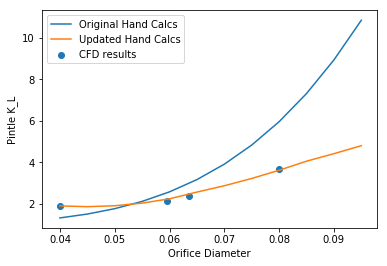

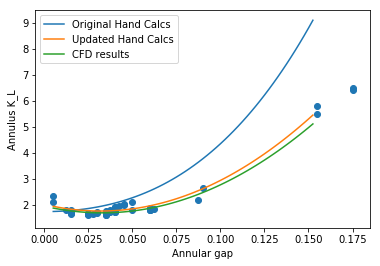

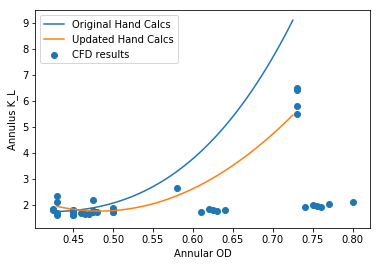

In [79]:
import math
import numpy as np
import csv
import matplotlib.pyplot as plt


def inch_to_meters(inch):
    meter = inch / 39.36996
    return(meter)

def meters_to_inch(meter):
    inch = meter * 39.36996
    return(inch)

# Geometry to be optimized


pintle_exit_dia       = inch_to_meters(np.arange(0.04, 0.1, 0.005))      
pintle_number_outlets = 12


pintle_outer_dia      = inch_to_meters(0.42)
annulus_outer_dia     = inch_to_meters(np.arange(0.43, 0.73, 0.005))


# other geometry 

pintle_entrance_dia   = inch_to_meters(0.44)   
pintle_inner_dia      = inch_to_meters(0.221)      

annulus_entrance_dia  = inch_to_meters(0.25)      
annulus_chamber_dia   = inch_to_meters(0.865)    
annulus_channel_depth = inch_to_meters(0.21)   
annulus_channel_width = inch_to_meters(0.25)     
annulus_hydrolic_dia  = annulus_outer_dia - pintle_outer_dia
annular_gap           = (annulus_outer_dia - pintle_outer_dia) / 2

# mass flow rates

pintle_mdot =  0.25 #kg/s 
annulus_mdot = 0.25 #kg/s 

# Fluid properties

fluid_pintle  = 'water'
fluid_annulus = 'water'

if fluid_pintle == 'water':
    pintle_rho             = 999.7     # kg/m^3
    pintle_dynvisc         = 0.001307  # N*s/m^2
    pintle_surface_tension = 0.0720    # N/m

elif fluid_pintle == 'LOX':
    pintle_rho             = 1141      # kg/m^3
    pintle_dynvisc         = 0.0001971 # N*s/m^2
    pintle_surface_tension = 0.01135   # N/m

if fluid_annulus == 'water':
    annulus_rho            = 999.7     # kg/m^3
    annulus_dynvisc        = 0.001307  # N*s/m^2
    annulus_surface_tension= 0.0720    # N/m 

elif fluid_annulus == 'IPA':
    annulus_rho       = 877.8         # kg/m^3  
    annulus_dynvisc   = 0.002         # N*s/m^2
    annulus_surface_tension= 0.0720*0.3 + 0.0209*0.7    # N/m 70% IPA estimate

# Original Loss coefficent guesses, 
# these values do not produce reliable results when scaled to larger injectors; 


pintle_k_1 = 0.07   # loss coefficient for first entrance region (from Munson)
pintle_k_2 = 2      # inner region for transition between centeral flow path and radial holes (guess based on Munson)
pintle_k_3 = 1      # Exit region to atmosphere (from Munson)

annulus_k_1 = 0.07         # Transition from entrance to manifold  (2.25 guess based on Munson)
annulus_k_2 = 4      # Transition between manifold and 3 inner channels (2.8 guess based on Munson)
annulus_k_3 = 1.2    # Transition from channels into annular chamber (from Munson)
                         #(1-annulus_channel_area/annulus_chamber_area)**2
annulus_k_4 = 2         # Transition from upper fuel chamber diameter to annular gap (0.07 from Munson)
annulus_k_5 = 1.75      # exit region to atmosphere (1 from Munson)

# Area calculations

pintle_entrance_area  = math.pi*(pintle_entrance_dia/2)**2          # m^2 , flow area 1
pintle_inner_area     = math.pi*(pintle_inner_dia/2)**2             # m^2 , flow area 2
pintle_exit_area      = pintle_number_outlets * math.pi*(pintle_exit_dia/2)**2      # m^2 , flow area 3, 12 small diameter holes


annulus_entrance_area = (math.pi*(annulus_entrance_dia/2)**2)*3     # m^2 , flow area 1
annulus_manifold_area = (annulus_channel_depth * annulus_channel_width)* 6  # m^2 , flow area 2
annulus_channel_area  = (annulus_channel_depth * annulus_channel_width)* 3  # m^2 , flow area 3
annulus_chamber_area  = math.pi*(annulus_chamber_dia/2)**2          # m^2 , flow area 4
annulus_inner_area    = math.pi*(pintle_outer_dia/2)**2                    # m^2 
annulus_outer_area    = math.pi*(annulus_outer_dia/2)**2            # m^2 
annulus_exit_area     = annulus_outer_area - annulus_inner_area     # m^2 , flow area 5

# variables which will be used later

pintle_entrance_velocity = []; pintle_inner_velocity = []; pintle_exit_velocity = []
annulus_entrance_velocity = []; annulus_manifold_velocity = []; annulus_channel_velocity = []
annulus_chamber_velocity = []; annulus_exit_velocity = []

pintle_dynamic_pressure_in = []; annulus_dynamic_pressure_in = []
pintle_entrance_re = []; pintle_exit_re = []
annulus_entrance_re = []; annulus_exit_re = []

pintle_K_L2 = []; pintle_K_L3 = []
pintle_hl_tot = []; pintle_hL_total_psi = []
annulus_hl_tot = []; annulus_hL_total_psi = []
pintle_K_L = []; annulus_K_L = []; annulus_K_L2 = []; annulus_K_L3 = []; annulus_K_L4 = [];
pintle_velocity_scale = [] ; annulus_velocity_scale = []
pintle_turbulence_intensity = [] ; annulus_turbulence_intensity = []
pintle_exit_weber = [] ; annulus_exit_weber = []

pintle_force = [] ; annulus_force = [] ; pintle_force_tot = [] ; annulus_force_tot = []
momentum_ratio = [] ; momentum_ratio_tot = []


# Pintle calculations

for i,value in enumerate(pintle_exit_area):

# Velocity calculations 
    pintle_entrance_velocity.append(pintle_mdot / (pintle_rho * pintle_entrance_area))  
    pintle_inner_velocity.append(pintle_mdot / (pintle_rho * pintle_inner_area))  
    pintle_exit_velocity.append(pintle_mdot / (pintle_rho * pintle_exit_area[i])) 


# orginal calculated head losses in kPa
    pintle_hL_1 = (pintle_k_1*0.5*pintle_rho*pintle_entrance_velocity[i]**2)/1000 
    pintle_hL_2 = (pintle_k_2*0.5*pintle_rho*pintle_inner_velocity[i]**2)/1000 
    pintle_hL_3 = (pintle_k_3*0.5*pintle_rho*pintle_exit_velocity[i]**2)/1000 
    pintle_hl_tot.append(pintle_hL_1 + pintle_hL_2+pintle_hL_3)

#convert to psi from kPa for head loss
    pintle_hL_1_psi = pintle_hL_1 * 0.1450377    
    pintle_hL_2_psi = pintle_hL_2 * 0.1450377    
    pintle_hL_3_psi = pintle_hL_3 * 0.1450377    
    pintle_hL_total_psi.append((pintle_hL_1_psi+pintle_hL_2_psi+pintle_hL_3_psi))  

# calculate overal loss coefficient
    pintle_K_L.append((2*pintle_hl_tot[i]*1000)/(pintle_rho*pintle_exit_velocity[i]**2))
    
    
# The equations below were developed using a series of 2^2 factorial experiments.
# The two variables used for these experiements were the pintle exit diameter and the
# pintle inner diameter. The experiments were carried out using Star CCM+ CFD software
# using the V3 injector geometry. These equations were taken from the curve fit produced 
# for the data using R studio.  
    
    pintle_kl_f = [0.14,0.18,-18.128, 1915.254, 0, 172.497, -1552.240]
    
    if pintle_exit_dia[i] < inch_to_meters(0.06):
        loss_coef = pintle_kl_a
    elif pintle_exit_dia[i] < inch_to_meters(0.08): 
        loss_coef = pintle_kl_b
    elif pintle_exit_dia[i] < inch_to_meters(0.1):
        loss_coef = pintle_kl_c
    elif pintle_exit_dia[i] < inch_to_meters(0.12):
        loss_coef = pintle_kl_d
    elif pintle_exit_dia[i] < inch_to_meters(0.14):
        loss_coef = pintle_kl_e
    else:
        loss_coef = pintle_kl_f
        
    x0 = loss_coef[2]
    x1 = loss_coef[3]*meters_to_inch(pintle_exit_dia[i])**2
    x2 = loss_coef[4]*meters_to_inch(pintle_inner_dia)**2
    x3 = loss_coef[5]*meters_to_inch(pintle_inner_dia)
    x4 = loss_coef[6]*(meters_to_inch(pintle_exit_dia[i])*meters_to_inch(pintle_inner_dia))
          
    pintle_K_L2.append(x0+x1+x2+x3+x4)  

# Annulus calculations

for i,value in enumerate(annulus_exit_area):
    
# Velocity calculations
    annulus_entrance_velocity.append(annulus_mdot / (annulus_rho * annulus_entrance_area)) 
    annulus_manifold_velocity.append(annulus_mdot / (annulus_rho * annulus_manifold_area))
    annulus_channel_velocity.append(annulus_mdot / (annulus_rho * annulus_channel_area))
    annulus_chamber_velocity.append(annulus_mdot / (annulus_rho * annulus_chamber_area))  
    annulus_exit_velocity.append(annulus_mdot / (annulus_rho * annulus_exit_area[i])) 

# cavitation check
    pressure_local = 413685.4  #pa
    pressure_vapor = 15700     #pa
    
    pressure_drop = pressure_local - pressure_vapor
    
    kin1 = 0.5*annulus_rho*annulus_entrance_velocity[i]
    kin2 = 0.5*annulus_rho*annulus_manifold_velocity[i]
    kin3 = 0.5*annulus_rho*annulus_channel_velocity[i]
    kin4 = 0.5*annulus_rho*annulus_chamber_velocity[i]
    kin5 = 0.5*annulus_rho*annulus_exit_velocity[i]
    
    #print('%8.3f %8.3f %8.3f %8.3f %8.3f %8.3f \n' % (pressure_drop,kin1, kin2, kin3, kin4, kin5))
    
# original calculated head losses in kPa
    annulus_hL_1 = (annulus_k_1*0.5*annulus_rho*annulus_entrance_velocity[i]**2)/1000 
    annulus_hL_2 = (annulus_k_2*0.5*annulus_rho*annulus_manifold_velocity[i]**2)/1000
    annulus_hL_3 = (annulus_k_3*0.5*annulus_rho*annulus_channel_velocity[i]**2)/1000
    annulus_hL_4 = (annulus_k_4*0.5*annulus_rho*annulus_chamber_velocity[i]**2)/1000 
    annulus_hL_5 = (annulus_k_5*0.5*annulus_rho*annulus_exit_velocity[i]**2)/1000  
    annulus_hl_tot.append(annulus_hL_1 + annulus_hL_2 + annulus_hL_3 + annulus_hL_4 + annulus_hL_5)

#convert to psi from kPa for head loss
    annulus_hL_1_psi = annulus_hL_1 * 0.1450377  
    annulus_hL_2_psi = annulus_hL_2 * 0.1450377    
    annulus_hL_3_psi = annulus_hL_3 * 0.1450377    
    annulus_hL_4_psi = annulus_hL_4 * 0.1450377
    annulus_hL_5_psi = annulus_hL_5 * 0.1450377
    annulus_hL_total_psi.append((annulus_hL_1_psi+annulus_hL_2_psi+annulus_hL_3_psi+
                            annulus_hL_4_psi+annulus_hL_5_psi))  

# calculate overal loss coefficient
    annulus_K_L.append((2*annulus_hl_tot[i]*1000)/(annulus_rho*annulus_exit_velocity[i]**2))
    #annulus_K_L_out.append((2*annulus_hl_tot[i]*1000)/(annulus_rho*annulus_exit_velocity[i]**2))

# The equations below were developed using multiple factorial experiments.
# The three variables were used for these experiements; Annulus OD, Pintle OD, #mass flow rate. 
# The mass flow rate was found to have only weak correlations to the resutls.
# pintle inner diameter. The experiments were carried out using Star CCM+ CFD software
# using the V3 injector geometry. These equations were taken from the curve fit produced 
# for the data using R studio.  
    
    x0b = 6.566
    x1b = 63.204*meters_to_inch(annulus_outer_dia[i])**2
    x2b = 56.572*meters_to_inch(pintle_outer_dia)**2
    x3b = -22.268*meters_to_inch(annulus_outer_dia[i])
    x4b = -92.496*meters_to_inch(pintle_outer_dia)*meters_to_inch(annulus_outer_dia[i])
    
    annulus_K_L2.append(x0b+x1b+x2b+x3b+x4b)
    
    x0c = 1.5142
    x1c = 59.538*meters_to_inch(annulus_outer_dia[i])**2
    x2c = 80.6057*meters_to_inch(pintle_outer_dia)**2
    #x3c = -22.268*meters_to_inch(annulus_outer_dia[i])
    x4c = -137.6366*meters_to_inch(pintle_outer_dia)*meters_to_inch(annulus_outer_dia[i])
    
    annulus_K_L3.append(x0c+x1c+x2c+x4c)

cfd_pintle_KL  = [1.87, 2.11, 2.37, 3.69]
cfd_pintle_dia = [0.04, 0.0595, 0.0635, .08] 



cfd_annulus_KL  = [2.115, 5.49, 5.789, 1.705,
    1.619, 6.499, 2.362, 6.422, 2.6498, 1.799, 1.797, 1.796,
    1.801, 1.844, 1.887, 1.790, 1.742, 1.737, 1.801,
    1.635, 1.677, 1.647, 1.631, 1.660, 1.732, 1.704,
    1.759, 1.751, 1.782, 2.195, 1.811, 1.848, 1.795,
    2.126, 2.046, 1.993, 1.922,
    1.914, 1.955, 1.823, 1.834, 1.781, 1.752,
    1.804, 1.73, 1.691, 1.67, 1.664, 1.66]


cfd_annulus_OD = [0.43, 0.73, 0.73, 0.43, 0.43, 0.73, 0.43, 0.73, 0.58, 0.5, 0.5,
    0.5, 0.5,0.5,0.5,0.5,0.5,0.5,0.45,0.45,0.45,0.45,0.45,0.45,
    0.45,0.45,0.475,0.475,0.475,0.475,0.425,0.425,0.45, 0.8,0.77,0.75,0.76,0.74,
    0.755,0.64,0.62,0.63,0.61,0.625,0.48,0.46,0.47,0.45,0.465]


cfd_annulus_gap = [0.005,0.155,0.155,
    0.025,0.025,0.175,0.005,0.175,0.09,0.06,0.06,
    0.04,0.06,0.06,0.06,0.04,0.04,0.04,
    0.015,0.035,0.035,0.035,0.035,0.015,
    0.015,0.015,0.0375,0.0375,0.0375,
    0.0875,0.0125,0.0625,0.05,0.05,
    0.045,0.045,0.04,0.04,0.0425,
    0.04,0.04,0.035,0.035,0.0375,
    0.03,0.03,0.025,0.025,0.0275]



hand_annulus_KL  = [2.223, 1.949, 1.859, 1.791, 2.014]


plt.plot(meters_to_inch(pintle_exit_dia), pintle_K_L, 
         meters_to_inch(pintle_exit_dia), pintle_K_L2)
plt.scatter(cfd_pintle_dia, cfd_pintle_KL,)
plt.ylabel('Pintle K_L')
plt.xlabel('Orifice Diameter')
#plt.yscale('log')
#plt.xscale('log')
plt.legend(['Original Hand Calcs','Updated Hand Calcs','CFD results'])
plt.show()


plt.plot(meters_to_inch(annular_gap), annulus_K_L, 
        meters_to_inch(annular_gap), annulus_K_L2,
        meters_to_inch(annular_gap), annulus_K_L3)
plt.scatter(cfd_annulus_gap, cfd_annulus_KL,)
plt.ylabel('Annulus K_L')
plt.xlabel('Annular gap')
plt.legend(['Original Hand Calcs','Updated Hand Calcs','CFD results'])
plt.show()


plt.plot(meters_to_inch(annulus_outer_dia), annulus_K_L, 
        meters_to_inch(annulus_outer_dia), annulus_K_L2)
plt.scatter(cfd_annulus_OD, cfd_annulus_KL,)
plt.ylabel('Annulus K_L')
plt.xlabel('Annular OD')
plt.legend(['Original Hand Calcs','Updated Hand Calcs','CFD results'])
plt.show()




# Version 2 Pintle Calculator

This calculator was used to design the Version 2 pintle. This design was manufactured in aluminum and hydro tested. The testing results showed that the annulur flow path into the chamber gave uneven flow out of the annulus. A new calculator was developed for the Version 3 which incorporates adjustments which were made to address the flow issue.



In [ ]:
import math
from mpmath import *
import numpy as np
from matplotlib import pyplot as plt


# Desired flow parameters
pintle_mdot = 0.4082    # kg/s  , desired Pintle mass flow rate
annulus_mdot = 0.5262   # kg/s  , desired Annulus mass flow rate

# Fluid properties

fluid_pintle  = 'water'
fluid_annulus = 'water'

if fluid_pintle == 'water':
    pintle_rho = 999.7          # kg/m^3
    pintle_dynvisc = 0.001307   # N*s/m^2

elif fluid_pintle == 'LOX':
    pintle_rho     = 1141        # kg/m^3
    pintle_dynvisc = 0.0001971   # N*s/m^2

if fluid_annulus == 'water':
    annulus_rho       = 999.7          # kg/m^3
    annulus_dynvisc   = 0.001307       # N*s/m^2

elif fluid_annulus == 'IPA':
    annulus_rho       = 877.8         # kg/m^3  
    annulus_dynvisc   = 0.002         # N*s/m^2
    

# V_2.0 geometry

def inch_to_meters(inch):
    meter = inch / 39.36996
    return(meter)

pintle_entrance_dia = inch_to_meters(0.402)   
pintle_inner_dia = inch_to_meters(0.221)      
pintle_exit_dia = inch_to_meters(0.0595)      

# V_2.0 Annulus

pipe_diameter         = inch_to_meters(0.402)    # m (0.402 " pipe diameter)
annulus_entrance_dia  = inch_to_meters(0.25)     # m (0.25 in) 
annulus_chamber_dia   = inch_to_meters(0.865)   # m (0.865 in)
annulus_inner_dia     = inch_to_meters(0.421)   # m (0.281 in) The outer diameter of the pintle
annulus_outer_dia     = inch_to_meters(0.4688)   # m (0.415 in)
annulus_hydrolic_dia  = annulus_outer_dia - annulus_inner_dia

# Area calculations

pintle_entrance_area  = math.pi*(pintle_entrance_dia/2)**2        # m^2 , flow area 1
pintle_inner_area     = math.pi*(pintle_inner_dia/2)**2        # m^2 , flow area 2
pintle_exit_area      = 12 * math.pi*(pintle_exit_dia/2)**2   # m^2 , flow area 3, 12 small diameter holes

pipe_area             = math.pi*(pipe_diameter/2)**2        # m^2 , flow area 1
annulus_entrance_area = math.pi*(annulus_entrance_dia/2)**2        # m^2 , flow area 2
annulus_chamber_area  = math.pi*(annulus_chamber_dia/2)**2        # m^2 , flow area 3
annulus_inner_area    = math.pi*(annulus_inner_dia/2)**2   # m^2 , flow area 4, 12 small diameter holes
annulus_outer_area    = math.pi*(annulus_outer_dia/2)**2   # m^2 , flow area 4, 12 small diameter holes
annulus_exit_area     = annulus_outer_area - annulus_inner_area

# velocity calculations

pintle_velocity_entrance  = pintle_mdot / (pintle_rho * pintle_entrance_area)  
pintle_inner_velocity     = pintle_mdot / (pintle_rho * pintle_inner_area)  
pintle_velocity_exit      = pintle_mdot / (pintle_rho * pintle_exit_area) 

pipe_fuel_velocity        = annulus_mdot / (annulus_rho * pipe_area)
annulus_entrance_velocity = annulus_mdot / (annulus_rho * annulus_entrance_area) 
annulus_chamber_velocity  = annulus_mdot / (annulus_rho * annulus_chamber_area)  
annulus_exit_velocity     = annulus_mdot / (annulus_rho * annulus_exit_area) 

# Entrance Dynamic Pressure

pintle_dynamic_pressure_in = (pintle_rho*pintle_velocity_entrance**2/2)* 0.1450377/1000
annulus_dynamic_pressure_in = (annulus_rho*pipe_fuel_velocity**2/2)* 0.1450377/1000

# Reynolds numbers

pintle_re_1 = (pintle_rho*pintle_velocity_entrance*pintle_entrance_dia)/pintle_dynvisc 
pintle_re_2 = (pintle_rho*pintle_inner_velocity*pintle_inner_dia)/pintle_dynvisc 
pintle_re_3 = (pintle_rho*pintle_velocity_exit*pintle_exit_dia)/pintle_dynvisc 

annulus_re_1 = (annulus_rho*pipe_fuel_velocity*pipe_diameter)/annulus_dynvisc 
annulus_re_2 = (annulus_rho*annulus_entrance_velocity*annulus_entrance_dia)/annulus_dynvisc 
annulus_re_3 = (annulus_rho*annulus_chamber_velocity*annulus_chamber_dia)/annulus_dynvisc 
annulus_re_4 = (annulus_rho*annulus_exit_velocity*annulus_hydrolic_dia)/annulus_dynvisc 

# Loss coefficents; taken from Fluids textbook

pintle_k_1 = 0.07   # loss coefficient for first entrance region
pintle_k_2 = 2      # inner region  (originally using 2, 3 puts this inline with experiment)
pintle_k_3 = 1      # Exit region (originally used value of 1, 4 puts this inline with experiment)

annulus_k_1 = 0.38      # Pipe to test jig (0.38)
annulus_k_2 = 1         # Test jig to fuel chamber (1)
annulus_k_3 = 0.04      # Fuel Chamber to annulus (0.04)
annulus_k_4 = 1         # Exit region (1)

# calculated head losses in kPa

pintle_hL_1 = (pintle_k_1*0.5*pintle_rho*pintle_velocity_entrance**2)/1000 
pintle_hL_2 = (pintle_k_2*0.5*pintle_rho*pintle_inner_velocity**2)/1000 
pintle_hL_3 = (pintle_k_3*0.5*pintle_rho*pintle_velocity_exit**2)/1000 
pintle_hl_tot = pintle_hL_1 + pintle_hL_2+pintle_hL_3

annulus_hL_1 = (annulus_k_1*0.5*annulus_rho*pipe_fuel_velocity**2)/1000 
annulus_hL_2 = (annulus_k_2*0.5*annulus_rho*annulus_entrance_velocity**2)/1000 
annulus_hL_3 = (annulus_k_3*0.5*annulus_rho*annulus_chamber_velocity**2)/1000 
annulus_hL_4 = (annulus_k_4*0.5*annulus_rho*annulus_exit_velocity**2)/1000 
annulus_hl_tot = annulus_hL_1 + annulus_hL_2 + annulus_hL_3 + annulus_hL_4

#convert to psi from kPa

pintle_hL_1_psi = pintle_hL_1 * 0.1450377    
pintle_hL_2_psi = pintle_hL_2 * 0.1450377    
pintle_hL_3_psi = pintle_hL_3 * 0.1450377    
pintle_hL_total_psi = (pintle_hL_1_psi+pintle_hL_2_psi+pintle_hL_3_psi) #* 2.5 #correction factor  

pintle_K_L = (2*pintle_hl_tot*1000)/(pintle_rho*pintle_velocity_exit**2)

annulus_hL_1_psi = annulus_hL_1 * 0.1450377  
annulus_hL_2_psi = annulus_hL_2 * 0.1450377    
annulus_hL_3_psi = annulus_hL_3 * 0.1450377    
annulus_hL_4_psi = annulus_hL_4 * 0.1450377    
annulus_hL_total_psi = (annulus_hL_1_psi+annulus_hL_2_psi+annulus_hL_3_psi+annulus_hL_4_psi)  

annulus_K_L = (2*annulus_hl_tot*1000)/(annulus_rho*annulus_exit_velocity**2)

print("Calculated flow values\n")
print('Pintle calculations if using %s\n' %fluid_pintle)
print('Pintle entrance velocity    = %8.3f m/s' % pintle_velocity_entrance)
print('Pintle inner velocity       = %8.3f m/s' % pintle_inner_velocity)
print('Pintle exit velocity        = %8.3f m/s' % pintle_velocity_exit)

print('Pintle entrance Reynolds #  = %8.0f' % pintle_re_1)
#print('Pintle Reynolds # 2         = %10.0f' % pintle_re_2)
print('Pintle exit Reynolds #      = %8.0f' % pintle_re_3)
print('Pintle headloss 1           = %8.3f psi' % pintle_hL_1_psi)
print('Pintle headloss 2           = %8.3f psi' % pintle_hL_2_psi)
print('Pintle headloss 3           = %8.3f psi' % pintle_hL_3_psi)
print('Pintle Total head loss      = %8.2f psi\n' % pintle_hL_total_psi)
print('Pintle  Total head loss     = %8.3f kPa' % pintle_hl_tot)

print('Pintle  KL total            = %8.3f \n' % pintle_K_L)

print('Pintle Entrance Dynamic Pressure = %8.3f \n' % pintle_dynamic_pressure_in)



print('Annulus calculations if using %s\n' %fluid_annulus)
print('Pipe fuel velocity          = %8.3f m/s' % pipe_fuel_velocity)
print('annulus entrance velocity   = %8.3f m/s' % annulus_entrance_velocity)
print('annulus inner velocity      = %8.3f m/s' % annulus_chamber_velocity)
print('annulus exit velocity       = %8.3f m/s' % annulus_exit_velocity)

print('annulus entrance Reynolds # = %8.0f' % annulus_re_1)
#print('annulus Reynolds # 2        = %10.3f' % annulus_re_2)
print('annulus exit Reynolds #     = %8.0f' % annulus_re_3)

#print('annulus headloss 1          = %8.3f psi' % annulus_hL_1_psi)
#print('annulus headloss 2          = %8.3f psi' % annulus_hL_2_psi)
#print('annulus headloss 3          = %8.3f psi' % annulus_hL_3_psi)
#print('annulus headloss 3          = %8.3f psi' % annulus_hL_4_psi)
print('annulus Total head loss     = %8.3f kPa' % annulus_hl_tot)
#print('annulus Total head loss     = %8.2f psi\n' % annulus_hL_total_psi)

print('annulus KL total            = %8.3f \n' % annulus_K_L)

print('Annulus Entrance Dynamic Pressure = %8.3f \n' % annulus_dynamic_pressure_in)



# Pintle V1 calculations - old

In [ ]:
# Pintle V1 Calculator

import math
from mpmath import *
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt


# Desired flow parameters

pintle_mdot = 0.4082332     # kg/s  , desired LOX mass flow rate
annulus_mdot = 0.5261671     # kg/s  , desired Fuel mass flow rate

pintle_pressure_drop_psi   =  70
annulus_pressure_drop_psi  =  70


def area(diameter):
    x = math.pi*(diameter/2)**2
    return (x)

def area_to_diameter(area):
    2*math.sqrt(area / math.pi )
    return (diameter)

def minor_loss(coef,density,velocity):
    loss_pa = (coef*0.5*density*velocity**2)
    return (loss_pa)

def pa_to_psi(pressure):
    psi = (pressure * 0.1450377)/1000 
    return(psi)

def psi_to_pa(pressure):
    pa = (pressure / 0.1450377) * 1000
    return(pa)

def meters_to_inch(meters):
    inch = meters * 39.36996
    return(inch)

def inch_to_meters(inch):
    meter = inch / 39.36996
    return(meter)

def reynolds(rho, velocity, diameter, dynamic_viscosity):
    reynolds = (rho*velocity*diameter)/dynamic_viscosity
    return(reynolds)


# minimum /maximum values

pintle_outer_diameter = inch_to_meters(0.281)   # current outer diameter of pintle
pintle_circumference = pintle_outer_diameter * np.pi

min_wall_thickness = inch_to_meters(0.08)   # a very small wall thickness, maybe too small
min_space_size = inch_to_meters(0.04)          # a wild ass guess as to minimum distance between holes


#hole pattern possibilities

hole_pattern = pd.DataFrame({'holes':[8, 10, 12]})   # we can have 8, 10, or 12 radial holes


# Fluid properties

fluid_pintle  = 'water'
fluid_annulus = 'water'

if fluid_pintle == 'water':
    pintle_rho = 999.7          # kg/m^3
    pintle_dynvisc = 0.001307   # N*s/m^2

elif fluid_pintle == 'LOX':
    pintle_rho     = 1141        # kg/m^3
    pintle_dynvisc = 0.0001971   # N*s/m^2

if fluid_annulus == 'water':
    annulus_rho       = 999.7          # kg/m^3
    annulus_dynvisc   = 0.001307       # N*s/m^2

elif fluid_annulus == 'IPA':
    annulus_rho       = 877.8         # kg/m^3  
    annulus_dynvisc   = 0.002         # N*s/m^2
    


# flow geometry for V_1 pintle 

v1_pintle_entrance_dia = 0.010211   # m , 0.402 in
v1_pintle_inner_dia = 0.003048      # m , 0.12 in
v1_pintle_exit_dia = 0.000794       # m , 0.03125 in

v1_annulus_entrance_dia  = 0.0034544   # m , 0.136 in
v1_annulus_chamber_dia   = 0.0109855   # m , 0.4325 in
v1_annulus_inner_dia     = 0.0071374   # m , 0.281 in The outer diameter of the pintle
v1_annulus_outer_dia     = 0.0078867   # m , 0.3105 in
v1_annulus_hydrolic_dia = v1_annulus_outer_dia - v1_annulus_inner_dia


# Loss coefficents; taken from Fluids textbook

pintle_c_1 = 0.07   # loss coefficient for first entrance region
pintle_c_2 = 3      # inner region  (originally using 2, 4.5 puts this inline with experiment)
pintle_c_3 = 4      # Exit region (originally used value of 1, 3 puts this inline with experiment)

annulus_c_1 = 1         # loss coefficient for first entrance region
annulus_c_2 = 0.04      # Fuel Chamber to annulus
annulus_c_3 = 1         # Exit region



# import the data from the Orifice Experiment csv file


drill_chart = pd.read_csv('drill_size_chart.csv') # index_col='Size'

# column 0 is size, Column 1 is the decimal value in inches

diameter_meters = []
area_meters = []

for index, row in drill_chart.iterrows():
    diameter_meters.append(inch_to_meters(row['Decimal Equivalent (in)']))
    area_meters.append(area(inch_to_meters(row['Decimal Equivalent (in)'])))

drill_chart['diameter m'] = diameter_meters
drill_chart['drill area m^2'] = area_meters
    
#print(drill_chart[:])
#drill_chart.to_csv('drill_chart_metric.csv')
  
#print(drill_chart.iloc[0,1])
#print(drill_chart.iloc[0,2])





print("Calculations for the current pintle design\n")
print('Pintle calculations if using %s\n' %fluid_pintle)
#print('Pintle entrance velocity    = %8.3f m/s' % pintle_velocity_entrance)
#print('Pintle inner velocity       = %8.3f m/s' % pintle_inner_velocity)
#print('Pintle exit velocity        = %8.3f m/s\n' % pintle_velocity_exit)

#print('Pintle entrance Reynolds #  = %8.0f' % pintle_re_1)
#print('Pintle Reynolds # 2         = %10.0f' % pintle_re_2)
#print('Pintle exit Reynolds #      = %8.0f\n' % pintle_re_3)

#print('Pintle headloss 1           = %8.3f psi' % pintle_hL_1_psi)
#print('Pintle headloss 2           = %8.3f psi' % pintle_hL_2_psi)
#print('Pintle headloss 3           = %8.3f psi' % pintle_hL_3_psi)
#print('Pintle Total head loss      = %8.2f psi\n' % pintle_hL_total_psi)

#print('Annulus calculations if using %s\n' %fluid_annulus)
#print('annulus entrance velocity   = %8.3f m/s' % annulus_entrance_velocity)
#print('annulus inner velocity      = %8.3f m/s' % annulus_chamber_velocity)
#print('annulus exit velocity       = %8.3f m/s\n' % annulus_exit_velocity)

#print('annulus entrance Reynolds # = %8.0f' % annulus_re_1)
#print('annulus Reynolds # 2        = %10.3f' % annulus_re_2)
#print('annulus exit Reynolds #     = %8.0f\n' % annulus_re_3)

#print('annulus headloss 1          = %8.3f psi' % annulus_hL_1_psi)
#print('annulus headloss 2          = %8.3f psi' % annulus_hL_2_psi)
#print('annulus headloss 3          = %8.3f psi' % annulus_hL_3_psi)
#print('annulus Total head loss     = %8.2f psi\n' % annulus_hL_total_psi)



#desired head loss 70 psi

pintle_pressure_drop_psi = 70 

headloss_total = psi_to_pa(pintle_pressure_drop_psi)

headloss_1 = headloss_total * .0018     #alter these to change the percent of the total headloss
headloss_2 = headloss_total * .90
headloss_3 = headloss_total * .0982   

desired_velocity_1 = sqrt((2*headloss_1)/(pintle_c_1*pintle_rho))
desired_velocity_2 = sqrt((2*headloss_2)/(pintle_c_2*pintle_rho))
desired_velocity_3 = sqrt((2*headloss_3)/(pintle_c_3*pintle_rho))


#fprintf('Pintle Velocity 1        = #8.3f m/s\n',desired_velocity_1);
#fprintf('Pintle Velocity 2        = #8.3f m/s\n',desired_velocity_2);
#fprintf('Pintle Velocity 3        = #8.3f m/s\n',desired_velocity_3);


desired_area_1 = pintle_mdot/(pintle_rho * desired_velocity_1) 
desired_area_2 = pintle_mdot/(pintle_rho * desired_velocity_2) 
desired_area_3 = pintle_mdot/(pintle_rho * desired_velocity_3) 
desired_orifice_area = desired_area_3 /12        

desired_diameter_1 = 2*math.sqrt(desired_area_1 / math.pi )   #in meters
desired_diameter_2 = 2*math.sqrt(desired_area_2 / math.pi)    
desired_orifice_diameter = 2*math.sqrt(desired_orifice_area / math.pi) 

target_diameter_1 = meters_to_inch(desired_diameter_1) 
target_diameter_2 = meters_to_inch(desired_diameter_2) 
target_orifice_diameter = meters_to_inch(desired_orifice_diameter)

print('Pintle entrance diemeter     = %8.3f in\n' % target_diameter_1)
print('Pintle inner diemeter        = %8.3f in\n' % target_diameter_2)
print('Pintle orifice diemeter (12) = %8.3f in\n' % target_orifice_diameter)



#pintle_mdot = 0.4082332     # kg/s  , desired LOX mass flow rate
#annulus_mdot = 0.5261671    # kg/s  , desired Fuel mass flow rate
    

# flow geometry for V_1 pintle 

#v1_pintle_entrance_dia = 0.010211   # m , 0.402 in
#v1_pintle_inner_dia = 0.003048      # m , 0.12 in
#v1_pintle_exit_dia = 0.000794       # m , 0.03125 in

#v1_annulus_entrance_dia  = 0.0034544   # m , 0.136 in
#v1_annulus_chamber_dia   = 0.0109855   # m , 0.4325 in
#v1_annulus_inner_dia     = 0.0071374   # m , 0.281 in The outer diameter of the pintle
#v1_annulus_outer_dia     = 0.0078867   # m , 0.3105 in
#v1_annulus_hydrolic_dia = v1_annulus_outer_dia - v1_annulus_inner_dia




In [ ]:
Dim1 = inch_to_meters(0.0595 / 2)
print('Dim1 = %10.6f m' % Dim1)
